# Cumulative flow

Surface flow algorithms rely on the interconnection of nodes to pass information from one node to another in a downhill direction. Some algorithms include multiple downhill pathways where information is passed from a parent node to more than one downhill neighbours. Flow is split among $N$ downhill neighbours using

$$
\frac{Q_i}{Q_{\mathrm{total}}} = \frac{S_i^\alpha}{\sum_{i=1}^{N} S_i^{\alpha}}
$$

where $Q_{\mathrm{total}}$ is the total water discharge flowing through the node, $Q_i$ is the discharge into the immediate downstream node, $i$, and $\alpha$ is a partitioning parameter (usually $\alpha=\frac{1}{2}$). This notebook explores the propagation of information to downstream areas using one or two pathways.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import clock
%matplotlib inline

from quagmire import TopoMesh # all routines we need are within this class
from quagmire import tools as meshtools

In [2]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

x, y, bmask, = meshtools.elliptical_mesh(minX, maxX, minY, maxY, 0.05, 0.05, samples=100000, boundary_samples=1500)
x, y = meshtools.lloyd_mesh_improvment(x, y, bmask, iterations=5)
height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001

dm = meshtools.create_DMPlex_from_points(x, y, bmask)

mesh = TopoMesh(dm)
mesh.update_height(height)

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
 - Delaunay triangulation 1.307162s
 - Compute edge lengths 0.225934s
 - Construct neighbour array 0.576433s
 - Find boundaries 0.532538s
 - Build smoothing matrix 0.442865s
 - Sort nodes by field 0.178731s
 - Build downhill matrices 0.756707s


## One downhill neighbour

The `downhillMat` matrix houses the downstream neighbour network. It is the (weighted) sum of two matrices `adjacency1` and `adjacency2` which contain the first and second neighbours respectively. Below we replace `downhillMat` with `adjacency1`.

In [3]:
mesh._build_adjacency_matrix_1()
down1 = mesh.adjacency1.copy()
mesh.downhillMat = down1

In [4]:
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=24, codec='libx264', bitrate=2000, metadata=metadata)


DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
with writer.saving(fig, 'sombrero_1n.mp4', 100):
    while DX1.array.any() and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1
        
plt.close()

step 00000 -  remaining information  82827.000
step 00010 -  remaining information  69301.000
step 00020 -  remaining information  59686.000
step 00030 -  remaining information  50763.000
step 00040 -  remaining information  42505.000
step 00050 -  remaining information  35058.000
step 00060 -  remaining information  28263.000
step 00070 -  remaining information  22229.000
step 00080 -  remaining information  16949.000
step 00090 -  remaining information  12410.000
step 00100 -  remaining information  8495.000
step 00110 -  remaining information  5309.000
step 00120 -  remaining information  2889.000
step 00130 -  remaining information  1184.000
step 00140 -  remaining information  227.000
step 00150 -  remaining information  21.000


## Two downhill neighbours

This is the default setting in Quagmire. It uses the partitioning algorithm above to split information among downhill neighbours. If there is only one downhill neighbour then all the flow is directed to that node.

In [5]:
mesh._build_downhill_matrix()
down2 = mesh.downhillMat.copy()

In [6]:
DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
with writer.saving(fig, 'sombrero_2n.mp4', 100):
    while DX1.array.any() and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1
        
plt.close()

step 00000 -  remaining information  82827.000
step 00010 -  remaining information  70576.879
step 00020 -  remaining information  62347.693
step 00030 -  remaining information  54613.147
step 00040 -  remaining information  47349.492
step 00050 -  remaining information  40644.676
step 00060 -  remaining information  34423.373
step 00070 -  remaining information  28726.195
step 00080 -  remaining information  23528.982
step 00090 -  remaining information  18868.058
step 00100 -  remaining information  14708.656
step 00110 -  remaining information  11071.227
step 00120 -  remaining information  7944.352
step 00130 -  remaining information  5331.386
step 00140 -  remaining information  3230.130
step 00150 -  remaining information  1660.326
step 00160 -  remaining information  612.605
step 00170 -  remaining information  93.947
step 00180 -  remaining information  1.289
step 00190 -  remaining information  0.000
step 00200 -  remaining information  0.000
step 00210 -  remaining informatio

## $N$ downhill neighbours

Now we split flow into all downhill neighbours. There may be several recipient nodes that are lower than the parent node depending on the unstructured mesh.

In [7]:
mesh._build_downhill_matrix_neighbours()
downN = mesh.downhillMat.copy()

In [8]:
DX0 = mesh.gvec.duplicate()
DX1 = mesh.gvec.duplicate()
DX1.set(1.0)

plt.ion()
fig = plt.figure(1, figsize=(5,5))
ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
ax1.axes.set_aspect("equal")
ax1.axis('off')
ax1.triplot(x, y, mesh.tri.simplices, color="Black", linewidth=0.1, alpha=0.5, zorder=0)
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, DX1.array, vmin=0, vmax=1, cmap='YlOrRd', shading='gouraud', alpha=0.5, zorder=1)

step=0
with writer.saving(fig, 'sombrero_Nn.mp4', 100):
    while DX1.array.any() and step < 250: 
                
        im1.set_array(DX1.array)
        fig.canvas.draw()
        writer.grab_frame()

        if step%10 == 0:
            print "step {:05d} -  remaining information  {:.3f}".format(step, DX1.sum())

        step += 1

        DX1 = mesh.downhillMat*DX1
        DX0 += DX1

plt.close()

step 00000 -  remaining information  82827.000
step 00010 -  remaining information  74847.894
step 00020 -  remaining information  69980.978
step 00030 -  remaining information  65294.580
step 00040 -  remaining information  60747.092
step 00050 -  remaining information  56341.533
step 00060 -  remaining information  52069.332
step 00070 -  remaining information  47941.109
step 00080 -  remaining information  43975.117
step 00090 -  remaining information  40178.420
step 00100 -  remaining information  36540.865
step 00110 -  remaining information  33066.002
step 00120 -  remaining information  29755.099
step 00130 -  remaining information  26608.175
step 00140 -  remaining information  23632.547
step 00150 -  remaining information  20832.359
step 00160 -  remaining information  18206.182
step 00170 -  remaining information  15752.055
step 00180 -  remaining information  13471.890
step 00190 -  remaining information  11367.651
step 00200 -  remaining information  9440.274
step 00210 -  

## Compare upstream area

Examine the difference in upstream area for the three neighbour combinations.

$$
A_{\mathrm{upstream}} = \int_{\mathrm{upstream}} \!\!\!\! A(\xi) \, \mathrm{d}\xi
$$

In [9]:
def downhill_propagation(downhillMat, vector):
    """ time the propagation of information downhill """
    mesh.downhillMat = downhillMat
    t = clock()
    cumvec = mesh.cumulative_flow(vector)
    return cumvec, clock() - t

upstream_area_1n, t_1n = downhill_propagation(down1, mesh.area)
upstream_area_2n, t_2n = downhill_propagation(down2, mesh.area)
upstream_area_Nn, t_Nn = downhill_propagation(downN, mesh.area)

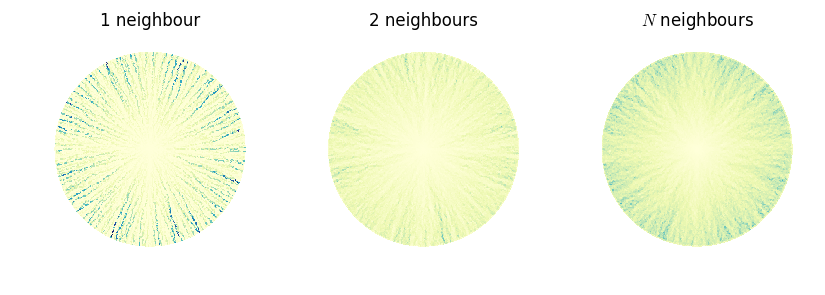

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,3))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

vmax = np.mean([upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_Nn.max()])
    
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n, cmap='YlGnBu', vmax=vmax)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n, cmap='YlGnBu', vmax=vmax)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_Nn, cmap='YlGnBu', vmax=vmax)

ax1.set_title('1 neighbour')
ax2.set_title('2 neighbours')
ax3.set_title('$N$ neighbours')

plt.show()

## Timings

The number of iterations to propogate information out of the domain increases with the number of downhill neighbours. One downhill neighbour is the fastest, yet the least realistic. Two downhill neighbours offers a good compromise between realistic flow and computation time.

In [11]:
def timed_downhill_propagation(downhillMat, vector):
    """ time the propagation of information downhill """
    mesh.gvec.setArray(vector)
    DX0 = mesh.gvec.copy()
    DX1 = mesh.gvec.copy()

    DX1_sum = DX1.sum()
    tt = [0.]
    ua = [DX1_sum]
    
    step = 0
    t = clock()
    while DX1_sum > 1e-12:
        
        DX1 = downhillMat*DX1
        DX0 += DX1
        DX1_sum = DX1.sum()
        
        tt.append(clock() - t)
        ua.append(DX1_sum)

    return ua, tt

ua_1n, tt_1n = timed_downhill_propagation(down1, mesh.area)
ua_2n, tt_2n = timed_downhill_propagation(down2, mesh.area)
ua_Nn, tt_Nn = timed_downhill_propagation(downN, mesh.area)

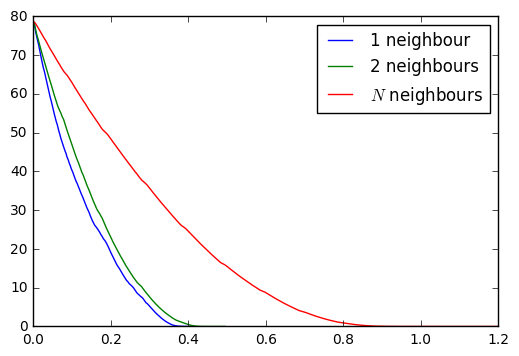

In [12]:
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(tt_1n, ua_1n, label='1 neighbour')
ax1.plot(tt_2n, ua_2n, label='2 neighbours')
ax1.plot(tt_Nn, ua_Nn, label='$N$ neighbours')
plt.legend()
plt.show()